# Import Libraries and Read the data

In [522]:
from sklearn.externals import joblib
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix
from matplotlib import pyplot
import seaborn as sns

#------------------- START FUNCTIONS -----------------------------------------#
def read_data(file):  
    #import the datasets and labels
    d = pd.read_csv(file, delimiter=",", engine='python',header='infer', dtype={ 'bookingID': np.int64, 'Accuracy': np.int32, 'Bearing': np.int32, 'acceleration_x': np.float64, 'acceleration_y': np.float64, 'acceleration_z': np.float64, 'gyro_x': np.float64, 'gyro_y': np.float64, 'gyro_z': np.float64, 'second': np.int32, 'Speed': np.int32  })
    print(file)
    return d

#------------------- END FUNCTIONS -----------------------------------------#


#read in the data
#fetch all files inside the features dir
files = os.listdir(os.getcwd()+'/features')

#create and append individual csv files to one single data frame
dataset = pd.DataFrame()
for file in files:
    file = os.getcwd()+'/features/'+file
    if file.endswith('.csv'):
        dataset = dataset.append(read_data(file))

labels = pd.read_csv('label.csv', delimiter=",", header='infer')

labels = labels[labels.bookingID != 0]

# Pre processing data

In [530]:
#rename columsn in the dataframe
pd.options.display.float_format = '{:.2f}'.format

labels = pd.read_csv('label.csv', delimiter=",", header='infer', dtype={ 'bookingID': np.int64, 'label': np.int})

#drop rows with BookingId values as 0
dataset = dataset[dataset.bookingID != 0]
labels = labels[labels.bookingID != 0]

#merge the two datasets with the right labels - Use keys from right frame only
merged = pd.merge(dataset, labels, left_on=['bookingID'], right_on=['bookingID'], how='left')

labels.drop_duplicates(subset ="bookingID", keep = False, inplace = True) 
orig_data = labels

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

columns = dataset.columns
dataset[columns] = dataset[columns].apply(pd.to_numeric, errors='coerce')

#drop rows with BookingId values as 0
dataset = dataset[dataset.bookingID != 0]
labels = labels[labels.bookingID != 0]

merged = remove_outlier(merged, 'second')
merged = merged.sort_values(['bookingID','second'],ascending=True)

# Feature Engineering

In [531]:
#Mean: the average value of the magnitude samples over a time window
mean_acc_gyro = merged.groupby('bookingID', as_index=False)\
        ['acceleration_x','acceleration_y','acceleration_z','gyro_x','gyro_y', 'gyro_z'].rolling(4).mean().reset_index()

mean_acc_gyro.set_index('level_1', drop=True, inplace=True)

merged.index[0] == mean_acc_gyro.index[0]

#STORE AND EXTRACT MEAN OF EVERY WINDOW -
merged['MEAN_ACC_X'] = mean_acc_gyro.acceleration_x[3::4]
merged['MEAN_ACC_Y'] = mean_acc_gyro.acceleration_y[3::4]
merged['MEAN_ACC_Z'] = mean_acc_gyro.acceleration_z[3::4]
merged['MEAN_GYRO_X'] = mean_acc_gyro.gyro_x[3::4]
merged['MEAN_GYRO_Y'] = mean_acc_gyro.gyro_y[3::4]
merged['MEAN_GYRO_Z'] = mean_acc_gyro.gyro_z[3::4]

#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
merged['CROSSOVER_ACC_X'] = (merged['acceleration_x'] > merged['MEAN_ACC_X'].bfill()).astype(int)
merged['CROSSOVER_ACC_Y'] = (merged['acceleration_y'] > merged['MEAN_ACC_Y'].bfill()).astype(int)
merged['CROSSOVER_ACC_Z'] = (merged['acceleration_z'] > merged['MEAN_ACC_Z'].bfill()).astype(int)

#Calculate Z-Crossing for accelerometer and gyroscope readings (how many times each point crosses the mean)
merged['CROSSOVER_GYRO_X'] = (merged['gyro_x'] > merged['MEAN_GYRO_X'].bfill()).astype(int)
merged['CROSSOVER_GYRO_Y'] = (merged['gyro_y'] > merged['MEAN_GYRO_Y'].bfill()).astype(int)
merged['CROSSOVER_GYRO_Z'] = (merged['gyro_z'] > merged['MEAN_GYRO_Z'].bfill()).astype(int)

#Variance: the average of the squared differences of the sample values from the mean value over a time window.
variance = merged.groupby('bookingID', as_index=False)\
        ['gyro_x','gyro_y', 'gyro_z'].rolling(4).var().reset_index()

variance.set_index('level_1', drop=True, inplace=True)

merged.index[0] == variance.index[0]

#STORE AND EXTRACT VA OF EVERY WINDOW -
merged['VAR_GYRO_X'] = variance.gyro_x[3::4]
merged['VAR_GYRO_Y'] = variance.gyro_y[3::4]
merged['VAR_GYRO_Z'] = variance.gyro_z[3::4]

merged['PITCH'] = np.arctan2(-merged.acceleration_x, np.sqrt(merged.acceleration_y * merged.acceleration_y + merged.acceleration_z * merged.acceleration_z)) * 57.3
merged['ROLL'] = np.arctan2(merged.acceleration_y, merged.acceleration_z) * 57.3


#GET MEAN OF ROLL AND PITCH FOR WINDOW
mean_pitch_roll = merged.groupby('bookingID', as_index=False)\
        ['ROLL','PITCH'].rolling(4).mean().reset_index()

mean_pitch_roll.set_index('level_1', drop=True, inplace=True)

merged.index[0] == mean_pitch_roll.index[0]

# MEAN AND ROLL EXTRACT FOR EACH WINDOW
merged['MEAN_ROLL'] = mean_pitch_roll.ROLL[3::4]
merged['MEAN_PITCH'] = mean_pitch_roll.PITCH[3::4]

#CHECK IF THE ACCELERATION POINTs AND GYROSCOPE CROSSES THE MEAN OF WINDOW : IF SO ASSIGN 1
merged['CROSSOVER_PITCH'] = (merged['ROLL'] > merged['MEAN_ROLL'].bfill()).astype(int)
merged['CROSSOVER_ROLL'] = (merged['PITCH'] > merged['MEAN_PITCH'].bfill()).astype(int)

#calculate bearing difference
bdiff = merged.groupby('bookingID', as_index=True)['Bearing'].diff()
merged['bearing_difference'] = bdiff

# intervals between data points
intervals =  merged.groupby('bookingID', as_index=True)['second'].diff()
merged['intervals'] = intervals

# speed diffrence between points
speed_diff =  merged.groupby('bookingID', as_index=True)['Speed'].diff()
merged['speed_diff'] = speed_diff

# calculate acceleration and bearing rates
merged['car_acceleration'] = abs(merged.speed_diff / merged.intervals)
merged['bearing_rate'] = abs(merged.bearing_difference / merged.intervals)

# distance covered at every point
merged['distance_covered'] = abs(merged.speed_diff * merged.intervals)

# Feature Aggregation

In [532]:
aggregates = merged.groupby('bookingID').agg({'distance_covered':['max'],
                            'bearing_rate':['max', 'var' ,'sum'],
                            'car_acceleration':['max'],
                            'intervals':['sum'],
                            'CROSSOVER_ROLL':['sum'],
                            'CROSSOVER_PITCH':['sum'],
                            'MEAN_PITCH':['max','std'],
                            'MEAN_ROLL':['max','std'],      
                            'VAR_GYRO_Z':['sum'],
                            'VAR_GYRO_Y':['sum'],
                            'VAR_GYRO_X':['sum'],
                            'CROSSOVER_GYRO_Z':['sum'],
                            'CROSSOVER_GYRO_Y':['sum'],
                            'CROSSOVER_GYRO_X':['sum'],
                            'CROSSOVER_ACC_Z':['sum'],
                            'CROSSOVER_ACC_Y':['sum'],
                            'CROSSOVER_ACC_X':['sum']})

aggregates.columns = aggregates.columns.map('|'.join).str.strip('|')

#merge aggregate vectors to the orginal label data
merged = pd.merge(orig_data, aggregates, left_on=['bookingID'], right_on=['bookingID'], how='left')

#rearrange columsn so that label goes to the end of frame
labels = merged['label']
merged = merged.drop(columns='label')
merged['label'] = labels

merged =  merged.dropna(how='any')   

merged = merged.drop(columns = ['bookingID'])

# Splitting (Stratified Sampling)

In [533]:
d = len(merged.columns) -1

#split the dataset
X = merged.iloc[:,:d]
y = merged.iloc[:,d]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=232323, stratify =y)

# Model Tuning (Gridsearch with 10 fold CV) : Only RUN ONCE

In [ ]:
"""
model = RandomForestClassifier(random_state = 3456)

grid_search_params = {'n_estimators': [160,180,190,200],
                    'max_features': [0.5,0.7,0.8,0.9],
                    'max_depth': [5,10,25,45],
                    'min_samples_split': [0.01,0.02,0.8]}


grid_search = GridSearchCV(estimator = model, param_grid = grid_search_params, cv = 10, n_jobs = 16, verbose = 3, scoring='roc_auc')

grid_search.fit(X_train,y_train)



model = grid_search.best_estimator_

grid_search.best_params_
"""

# Build Model with Tuned Parameters

In [535]:
# fit model no training data
model = RandomForestClassifier(n_estimators=180 , max_depth = 10, min_samples_split=0.01, max_features= 0.7, n_jobs = 17, verbose =0, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=0.7,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=180, n_jobs=17, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

# Evaluate Model
10 fold Cross validated AUC is done to get a better representation of model performance

In [536]:
model = joblib.load('FINAL_MODEL.sav')

cv_score = cross_val_score(model, X_test, y_test, cv=10, scoring='roc_auc')
cv_auc = sum(cv_score) / len(cv_score)

print(f"THE 10 fold cross Validated AUC is :: {cv_auc}")

THE 10 fold cross Validated AUC is :: 0.7211335808721733


In [ ]:
# Co

Text(51.0, 0.5, 'Actual Labels')

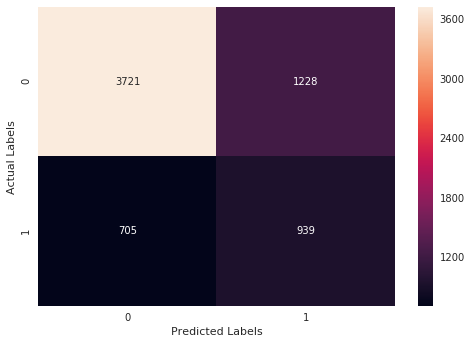

In [537]:
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)

ax= pyplot.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')

## Plot the Feature Importance Tables

In [538]:
feature_importances = pd.DataFrame(model.feature_importances_,index = X.columns,columns=['importance']).sort_values('importance',                                                                 ascending=False)
print(feature_importances)


                      importance
intervals|sum               0.33
bearing_rate|sum            0.08
distance_covered|max        0.08
MEAN_ROLL|std               0.06
MEAN_PITCH|std              0.06
VAR_GYRO_X|sum              0.04
VAR_GYRO_Z|sum              0.04
bearing_rate|var            0.03
car_acceleration|max        0.03
MEAN_PITCH|max              0.03
MEAN_ROLL|max               0.03
CROSSOVER_ROLL|sum          0.03
CROSSOVER_ACC_Z|sum         0.03
VAR_GYRO_Y|sum              0.02
bearing_rate|max            0.02
CROSSOVER_ACC_X|sum         0.02
CROSSOVER_GYRO_X|sum        0.02
CROSSOVER_ACC_Y|sum         0.02
CROSSOVER_GYRO_Z|sum        0.01
CROSSOVER_GYRO_Y|sum        0.01
CROSSOVER_PITCH|sum         0.01


## Plot ROC AUC curve and calculate AUC using 10 fold Cross validation

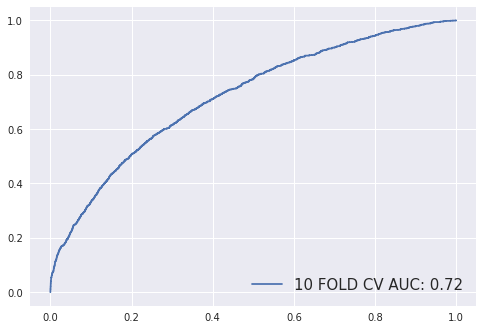

In [539]:
preds_cv = cross_val_predict(model, X_test, y_test, cv=10, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_test, preds_cv[:, 1])
cv_auc = auc(fpr, tpr)

pyplot.plot(fpr,tpr,label="10 FOLD CV AUC: {:.2f}".format( cv_auc ))
pyplot.legend(loc=4, prop={'size': 15})
pyplot.show()


In [ ]:
"""
filename = 'FINAL_MODEL.sav'
joblib.dump(model, filename, compress=3)
"""